# Bimodal (Audio + Visual) Speech Recognition


## Set up TensorFlow 2 and other libraries

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
import itertools
import os
import re
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pathlib

import pandas as pd

import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Using TensorFlow backend.


TF version: 2.0.0
Hub version: 0.6.0
GPU is available


## Reuse inception v3 in  Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299)


## Set up the dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = pathlib.Path('../dataset/Dataset_Img299')
data_dir=str(data_dir)

In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

Found 25199 images belonging to 2 classes.


In [6]:
train_generator = test_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, **dataflow_kwargs)

Found 100801 images belonging to 2 classes.


## Train Data for Image (Visual Speech)

In [37]:
data_dir = "../dataset/Dataset_Img299/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",save_to_dir='../dataset/img_aug'
                      )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=True,seed=9001, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=5,
      horizontal_flip=False,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.1, zoom_range=0.1,
      **datagen_kwargs)
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 51 classes.
Found 80656 images belonging to 51 classes.


## Train Data for Audio (Audio Speech)### Audio Input

In [38]:
data_dir_audio = "../dataset/Dataset_neg10db/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",color_mode='grayscale',save_to_dir='../dataset/aud_aug')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator_audio = valid_datagen.flow_from_directory(
    data_dir_audio, subset="validation", seed=9001, shuffle=True, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen_audio = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=False,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
    train_datagen_audio = valid_datagen
train_generator_audio = train_datagen_audio.flow_from_directory(
    data_dir_audio, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 51 classes.
Found 80656 images belonging to 51 classes.


## Combining the inputs - Audio-Video Data Generator

In [39]:
def generate_generator_multiple_fromgen(genX1,genX2):
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
training_generator = generate_generator_multiple_fromgen(train_generator,train_generator_audio)
val_generator = generate_generator_multiple_fromgen(valid_generator,valid_generator_audio) 


## Defining the model

Basic design is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module. Here and in other iterations, ablation studies on different designs post-feature extractor are evaluated.

For speed, we start out with a non-trainable `feature_extractor_layer`, but fine-tuning can be enabled for greater accuracy.

Exploring Siamese-type network as feature fusion, and resnet extractor

In [40]:
do_fine_tuning = True #@param {type:"boolean"}

In [42]:
BATCH_SIZE=BATCH_SIZE
EPOCHS=100

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 299, 299, 1)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 297, 297, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 297, 297, 32) 320         input_11[0][0]                   
____________________________________________________________________________________________

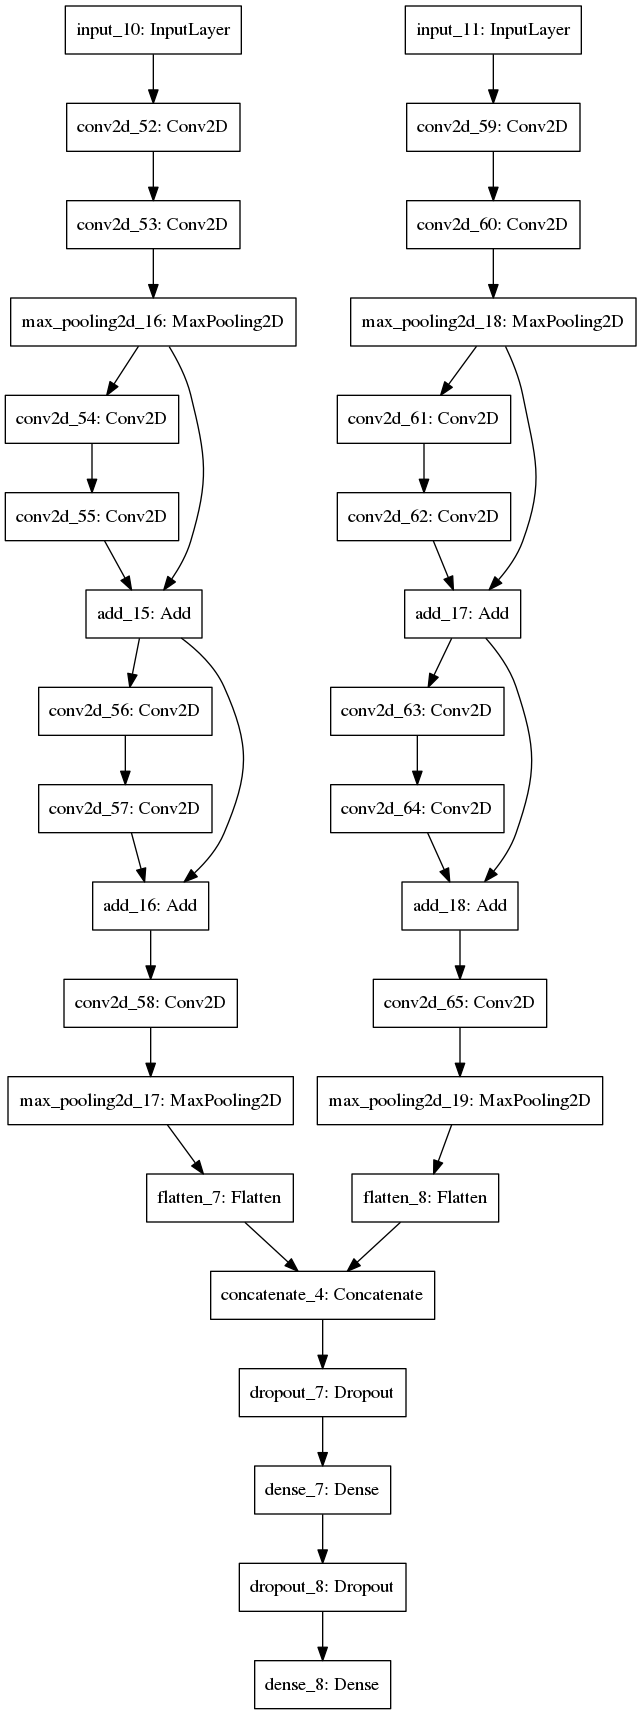

In [43]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
visible1 = Input(shape=(299,299,3))
###################

x = Conv2D(32, 3, activation='relu')(visible1)
x = Conv2D(64, 3, activation='relu')(x)
block_1_output = MaxPooling2D(3)(x)

x = Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = keras.layers.add([x, block_1_output])

x = Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = keras.layers.add([x, block_2_output])

x = Conv2D(64, 3, activation='relu')(block_3_output)
pool12 = MaxPooling2D(pool_size=(2, 2))(x)

##################
flat1 = Flatten()(pool12)
##################
# second input model
visible2 = Input(shape=(299,299,1))

xx = Conv2D(32, 3, activation='relu')(visible2)
xx = Conv2D(64, 3, activation='relu')(xx)
block_1_output2 = MaxPooling2D(3)(xx)

xx = Conv2D(64, 3, activation='relu', padding='same')(block_1_output2)
xx = Conv2D(64, 3, activation='relu', padding='same')(xx)
block_2_output2 = keras.layers.add([xx, block_1_output2])

xx = Conv2D(64, 3, activation='relu', padding='same')(block_2_output2)
xx = Conv2D(64, 3, activation='relu', padding='same')(xx)
block_3_output2 = keras.layers.add([xx, block_2_output2])

xx = Conv2D(64, 3, activation='relu')(block_3_output2)
pool22 = MaxPooling2D(pool_size=(2, 2))(xx)

################
flat2 = Flatten()(pool22)
# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
dropout1 = Dropout(rate=0.3)(merge)

# hidden1 = Dense(10, activation='relu')(merge)
hidden1 = Dense(51, activation='relu')(dropout1)

dropout2 = Dropout(rate=0.3)(hidden1)

output = Dense(51, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout2)
model = Model(inputs=[visible1, visible2], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='multiple_inputs_resnet_late.png')

In [44]:
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 299, 299, 1)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 297, 297, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 297, 297, 32) 320         input_11[0][0]                   
____________________________________________________________________________________________

## Training the model

In [46]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [47]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size



In [48]:
print(steps_per_epoch)
print(validation_steps)


2520
629


In [49]:
epochs = 100
temp_hist = []

In [ ]:
for ep in range(epochs):
    hist = model.fit_generator(
    training_generator,
    epochs=1, steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,verbose=1,workers=4,use_multiprocessing=True).history  
    temp_hist.append(hist) #if temp_hist is list
    
    saved_model_path = "./bimodal_late_adam_resnet_nosmooth_amsgrad_ep" + str(ep)
    model.save(saved_model_path +".h5")

    hist_df = pd.DataFrame(temp_hist)  #if temp_hist is list
    hist_df.to_csv('train_bimodal_late_adam_resnet_nosmooth_amsgrad_log.csv')     #if temp_hist is list


Epoch 1/1
 410/2520 [===>..........................] - ETA: 39:13 - loss: 3.8465 - accuracy: 0.0412

# Prediction 

In [31]:

test_dir = 'Dataset_Null/test'
# !ls

testgen_kwargs = dict(rescale=1./255, validation_split=.20)
testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    **testgen_kwargs)

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)

TEST_BATCH_SIZE = len(test_generator.filenames)

testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)


Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.


In [32]:

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples/BATCH_SIZE, verbose=True)



788/787 [==============================] - 226s 286ms/step


In [33]:
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_generator.class_indices)

In [34]:
labels = dict((v,k) for k,v in labels.items())

In [35]:
predictions = [labels.get(k) for k in predicted_class_indices]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_pred_null.csv",index=False)


In [36]:
results['label'] = results.apply(lambda x: x['Filename'].split('_')[2].split('.')[0], axis=1)
results.to_csv("results_pred_null2.csv",index=False)



# Performance Metrics

In [38]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report,mean_squared_error
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report



/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
conf_matrix = confusion_matrix(y_true=results.n_label, y_pred=results.n_prediction)
print('\nClassification Report:\n', classification_report(y_true=results.n_label, y_pred=results.n_prediction, labels=))


In [ ]:
import seaborn as sns

In [ ]:
results.Predictions.unique()

In [ ]:
ax = sns.heatmap(conf_matrix,annot=False,fmt="d",cmap="YlGnBu"
                 , xticklabels='auto', yticklabels='auto')
#                  xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
plt.subplots(figsize=(20,15))

cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm,annot=False,fmt="d",cmap=plt.cm.Blues,annot_kws={"size": 16},
                xticklabels=results.label.unique(),yticklabels=results.label.unique())